# Results and graphs

This tutorial demonstrates how the STK object model provides direct access to the data provider tools exposed by each object in STK that form the foundation of the report styles in the GUI.

The following example uses the `J2000 Position Velocity` report to demonstrate the retrieval of data through the object model. This report consists of specific J2000 data provider elements from two groups: `Cartesian Velocity` and `Cartesian Position`.

![The J2000 Position Velocity report contents](./img/object-model-report-contents.png)

## Launch a new STK instance

Start by launching a new STK instance. In this example, STKEngine is used.

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


Create an STK scenario using the STK Root object:

In [2]:
root = stk.new_object_root()
root.new_scenario("GraphsAndResults")

Once the scenario is created, it is possible to show a 3D graphics window by running:

RFBOutputContext()

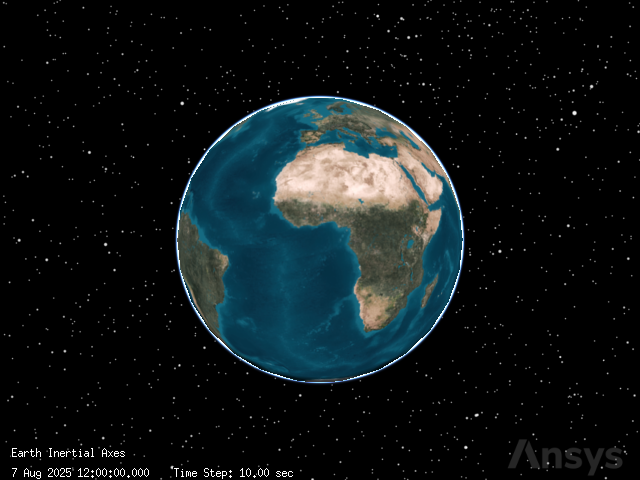

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


globe_widget = GlobeWidget(root, 640, 480)
globe_widget.show()

Show a 2D graphics window by running:

RFBOutputContext()

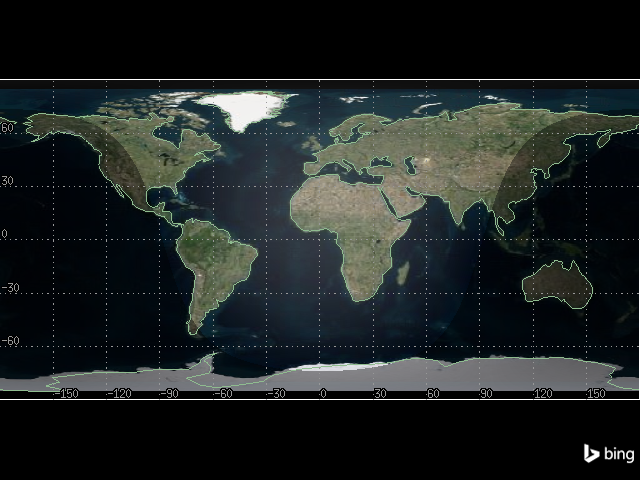

In [4]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import MapWidget


map_widget = MapWidget(root, 640, 480)
map_widget.show()

## Set the scenario time period

Using the newly created scenario, set the start and stop times. Rewind the scenario so that the graphics match the start and stop times of the scenario:

In [5]:
scenario = root.current_scenario
scenario.set_time_period("1 Jul 2020 17:14:00.00", "1 Jul 2020 17:29:00.00")
root.rewind()

## Adding a satellite to the scenario

Now that a new scenario is available, add a new satellite:

In [6]:
from ansys.stk.core.stkobjects import STKObjectType


satellite = root.current_scenario.children.new(
    STKObjectType.SATELLITE, "SatelliteTwoBody"
)

Ensure that the satellite's associated times use the scenario's times as well.

In [7]:
from ansys.stk.core.stkobjects import PropagatorTwoBody, PropagatorType


satellite.set_propagator_type(PropagatorType.TWO_BODY)

propagator = PropagatorTwoBody(satellite.propagator)
propagator.ephemeris_interval.set_start_and_stop_times(
    "1 Jul 2020 17:14:00.00", "1 Jul 2020 17:29:00.00"
)

propagator.propagate()

## Setup data providers for use in the object model

To retrieve the data for the `J2000 Position Velocity` report, setup its specific data providers for use in the Object Model. Use the various `DataProvider` interfaces to do this:

In [8]:
from ansys.stk.core.stkobjects import DataProviderGroup


cart_vel = DataProviderGroup(satellite.data_providers["Cartesian Velocity"])
cart_pos = DataProviderGroup(satellite.data_providers["Cartesian Position"])

cart_vel_j2000 = cart_vel.group.item("J2000")
cart_pos_j2000 = cart_pos.group.item("J2000")

The `DataProviderCollection` and `DataProviderGroup` variables can be used to access information about the `J2000 Position Velocity` report.

In [9]:
print('Some data providers available for the the "SatelliteTwoBody" satellite:')

data_providers = list(satellite.data_providers)
for index in range(len(data_providers)):
    if index > 9:
        print(f"\t...and {len(data_providers) - 10} more ")
        break
    print("\t" + str(data_providers[index].name))

print("Some data providers within the Cartesian Velocity group:")

for item in cart_vel.group:
    print("\t" + str(item.name))

print("Some data providers within the Cartesian Position group:")

for item in cart_pos.group:
    print("\t" + str(item.name))

Some data providers available for the the "SatelliteTwoBody" satellite:
	Active Constraints
	All Constraints
	Angles
	Articulation
	Astrogator Accel Hist
	Astrogator Log
	Astrogator MCS Ephemeris Segments
	Astrogator Maneuver Ephemeris Block Final
	Astrogator Maneuver Ephemeris Block History
	Astrogator Maneuver Ephemeris Block Initial
	...and 150 more 
Some data providers within the Cartesian Velocity group:
	TrueOfDateRotating
	Fixed
	ICRF
	MeanOfDate
	MeanOfEpoch
	TrueOfDate
	TrueOfEpoch
	B1950
	TEMEOfEpoch
	TEMEOfDate
	AlignmentAtEpoch
	J2000
Some data providers within the Cartesian Position group:
	TrueOfDateRotating
	Fixed
	ICRF
	MeanOfDate
	MeanOfEpoch
	TrueOfDate
	TrueOfEpoch
	B1950
	TEMEOfEpoch
	TEMEOfDate
	AlignmentAtEpoch
	J2000


The basic interfaces are now setup to compute information from the data providers that the report is using. Next, cast these objects to provide the `IDataProvider` interface with inputs so it can compute the proper data.

## Data provider "PreData" inputs

Some data providers require input data before the calculation can provide data results. This data is known as PreData. There are two ways to ascertain if PreData is required for a particular data provider:
- Refer to the data provider documentation which provides the format of the PreData if any is required.
- Retrieve the data provider schema and parse it for PreData tags.

Use the `DataProviderCollection.get_schema()` method to get the schema for all STK data providers.

In [10]:
schema = str(satellite.data_providers.get_schema())

Once the format of the PreData is known, set the `IDataProvider.pre_data` property. This property must be set before issuing the data provider's calculation method.

## Set the `pre_data` property on the `IDataProvider` interface

The following example demonstrates setting the satellite's object path as the PreData for the `RIC Coordinates` data provider and then calls the data provider's computation execution method.

In [11]:
from ansys.stk.core.stkobjects import DataProviderResult, DataProviderTimeVarying


provider = DataProviderTimeVarying(satellite.data_providers["RIC Coordinates"])

provider.pre_data = "Satellite/SatelliteTwoBody"

result = provider.execute("1 Jul 2020 17:14:00.00", "1 Jul 2020 17:29:00.00", 1)

## Data provider time inputs

In the `Time Period` section of the `Report` window in STK, highlight `J2000 Position Velocity` and click the `Specify Time Properties` radio button. The `J2000 Position Velocity` report uses a time period to provide the underlying data provider's information about what data to compute. Provide the same information to the object model data providers.

![Report time properties](./img/specify-time-properties.png)

## Retrieve the data

There are three ways to compute the data, depending on the data provider type. The first method requires a time interval and step size, the second requires only a time interval, and the third is independent of time.

Provide input information to the data providers by casting the data provider interfaces to the proper execution interface. In the case of the `Cartesian Velocity` and `Cartesian Position` data providers, cast to `DataProviderTimeVarying`:

In [12]:
vel_time_var = DataProviderTimeVarying(cart_vel_j2000)
pos_time_var = DataProviderTimeVarying(cart_pos_j2000)

Retrieve the information from the data providers. The data is always returned as a `DataProviderResult` object. Provide the `DataProviderTimeVarying.execute()` method of the `DataProviderTimeVarying` interfaces with the data provider inputs (start time, stop time, and step size):

In [13]:
vel_result = vel_time_var.execute("1 Jul 2020 17:14:00.00", "1 Jul 2020 17:29:00.00", 1)
pos_result = pos_time_var.execute("1 Jul 2020 17:14:00.00", "1 Jul 2020 17:29:00.00", 1)

`vel_result` and `pos_result` now contain the data from the `J2000 Cartesian Velocity` and `Cartesian Position` data providers, more data than the original report contained.

## Retrieve specific elements

Recall that the original `Cartesian Position Velocity` report contained only four elements of the `Cartesian Velocity J2000` group: `x`, `y`, `z`, and `speed`. Similarly, the `Cartesian Position J2000` data provider contained within your report style only contains three elements: `x`, `y`, and `z`.

When the J2000 data provider of `Cartesian Velocity` was executed, seven elements were retrieved instead of the four specifically contained in the
report, adding the `time`, `radial`, and `intrack` elements to the `DataProviderResult`. To be precise as possible, DataProviderResult` should contain only the elements which were contained in the original report. To do this, use the `DataProviderTimeVarying.execute_elements()` method.

First, specify in an array the elements to retrieve from the data provider. Next, pass the array into `DataProviderTimeVarying.execute_elements()`:

In [14]:
vel_elems = ["x", "y", "z", "speed"]
pos_elems = ["x", "y", "z"]

vel_result = vel_time_var.execute_elements(
    "1 Jul 2020 17:14:00.00", "1 Jul 2020 17:29:00.00", 60, vel_elems
)
pos_result = pos_time_var.execute_elements(
    "1 Jul 2020 17:14:00.00", "1 Jul 2020 17:29:00.00", 60, pos_elems
)

The original data from the `J2000 Position Velocity` report is now stored in `DataProviderResult` objects and ready to traverse.

## Traverse the result data

Review the original report. The data in the report consisted of time intervals with various elements.

![Original report](./img/original-report-data.png)

Similarly, the result needs to be cast to the appropriate interface to make use of the data. In the case of the `J2000 Cartesian Velocity` and `Position` data providers, that interface is the `DataProviderResultIntervalCollection`. Since each data provider result shares the same result type, consolidate the data traversal into one method, which takes a `DataProviderResult`:

In [15]:
def write_interval_data(result: DataProviderResult):
    """Traverse and write the data stored in a DataProviderResult."""
    intervals = result.intervals

    # iterate through the intervals
    for interval in intervals:
        print(f"Interval from {interval.start_time} to {interval.stop_time}:")

        # iterate through the datasets stored in the interval
        for data_set in interval.data_sets:
            print(
                f"\tFound {data_set.count} values for {data_set.element_name} (element type {data_set.element_type}, {data_set.dimension_name} dimension):"
            )

            # get the values stored in the datasets
            values = data_set.get_values()

            # iterate through the array of values
            for value in values:
                print(f"\t\t{str(value)}")

 **Note:** the type of data returned by the DataProvider can be determined using the `DataProviderResult.category` property, which returns an enumeration describing the interface. The `DataProviderResult.value` property is then cast to one of three interfaces, depending on the category enumeration: `DataProviderResultIntervalCollection`, `DataProviderResultSubSectionCollection`, or `DataProviderResultTextMessage`.

## Complete the output

Finally, call the method with `DataProviderResult` arguments. The data from the `J2000 Position Velocity` report is traversed and output:

In [16]:
print("Position Results:")
write_interval_data(pos_result)
print("Velocity Results:")
write_interval_data(vel_result)

Position Results:
Interval from 1 Jul 2020 17:14:00.000 to 1 Jul 2020 17:29:00.000:
	Found 16 values for x (element type 0, Distance dimension):
		6678.136999999842
		6662.055595999814
		6613.888738883715
		6533.868407417515
		6422.379991449177
		6279.960435813884
		6107.295654327432
		5905.217226323169
		5674.698391641722
		5416.849363363476
		5132.911980855586
		4824.253728889795
		4492.361151630885
		4138.832693218803
		3765.3709994230403
		3373.77471744714
	Found 16 values for y (element type 0, Distance dimension):
		1.2844455118041068e-07
		407.04478219807294
		812.1291759033289
		1213.3022344024714
		1608.6318484279448
		1996.2140516114755
		2374.1821902710767
		2740.715913492852
		3094.049940212913
		3432.4825610729454
		3754.3838341085398
		4058.203434790289
		4342.478122619497
		4605.838788311895
		4847.017047632431
		5064.851350122475
	Found 16 values for z (element type 0, Distance dimension):
		-0.0014439285727015064
		221.00581861546254
		440.9486841830188
		658.767875138

As previously noted, it is up to you to decide in what unit the data is returned. Issuing the following command before calling `write_interval_data()` changes the data that is output to be displayed in meters per second, rather then kilometers per second.

In [17]:
root.units_preferences.set_current_unit("DistanceUnit", "m")

write_interval_data(pos_result)
write_interval_data(vel_result)

Interval from 1 Jul 2020 17:14:00.000 to 1 Jul 2020 17:29:00.000:
	Found 16 values for x (element type 0, Distance dimension):
		6678136.999999843
		6662055.595999814
		6613888.738883715
		6533868.407417515
		6422379.991449177
		6279960.435813884
		6107295.654327433
		5905217.226323169
		5674698.391641722
		5416849.3633634765
		5132911.980855586
		4824253.728889795
		4492361.151630885
		4138832.693218803
		3765370.99942304
		3373774.7174471403
	Found 16 values for y (element type 0, Distance dimension):
		0.00012844455118041069
		407044.78219807293
		812129.1759033289
		1213302.2344024715
		1608631.8484279448
		1996214.0516114754
		2374182.1902710767
		2740715.913492852
		3094049.940212913
		3432482.5610729456
		3754383.83410854
		4058203.434790289
		4342478.122619498
		4605838.788311895
		4847017.047632431
		5064851.350122475
	Found 16 values for z (element type 0, Distance dimension):
		-1.4439285727015063
		221005.81861546254
		440948.6841830188
		658767.8751383198
		873414.34177917